In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import nltk

nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/intansk/coba-df/main/dataTiktok.csv", encoding='latin1')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,ef8fdd8f-9910-4186-935c-14b387835ba6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Lag parah padahal sinyal bagus,1,0,25.2.4,2024-06-08 06:30:51,NaN,NaN,25.2.4
1,6489418e-2a58-4bf9-be62-ad396e67ba65,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Nge ug,4,0,35.0.4,2024-06-08 06:29:55,NaN,NaN,35.0.4
2,6b32dbe4-e0a2-440a-8247-d1d749de5979,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat bagus dong tentunyaaað¯ð¯ð¯,5,0,34.5.6,2024-06-08 06:28:54,NaN,NaN,34.5.6
3,e5244b83-928f-48cf-bee8-59eefe231c84,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Bagys dan gampang ngedaptarin nya,5,0,NaN,2024-06-08 06:28:52,NaN,NaN,NaN
4,f65a8d42-6271-4605-8bdd-0e7b4cb861ae,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,BagusÂ² ajh,4,0,34.3.3,2024-06-08 06:26:25,NaN,NaN,34.3.3


# Cleaning

In [3]:
df = df[['content', 'score']]
df

,content,score
0,Lag parah padahal sinyal bagus,1
1,Nge ug,4
2,sangat bagus dong tentunyaaað¯ð¯ð¯,5
3,Bagys dan gampang ngedaptarin nya,5
4,BagusÂ² ajh,4
...,...,...
2995,Banyak banget mengambil ruang penyimpanan hand...,1
2996,Bagus banget suka banget video yg paling aku s...,5
2997,bagus,5
2998,Lemiot gak keudu2 Dari pgi sampe sore,1


In [4]:
df.shape

(3000, 2)

In [5]:
df = df.drop_duplicates(subset=['content'])
df.duplicated().sum()

0

In [6]:
df = df.dropna()
df.isnull().sum()

content    0
score      0
dtype: int64

In [7]:
def clean_twitter_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?://\S+', '', text)

  text = re.sub(r'[^A-Za-z0-9 ]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()

  return text

df['content'] = df['content'].apply(clean_twitter_text)

In [8]:
df['content'] = df['content'].str.lower()
df.head()

,content,score
0,lag parah padahal sinyal bagus,1
1,nge ug,4
2,sangat bagus dong tentunyaaa,5
3,bagys dan gampang ngedaptarin nya,5
4,bagus ajh,4


In [9]:
def filter_tokens_by_length(dataframe, column, min_words, max_words):
    words_count = dataframe[column].astype(str).apply(lambda x: len(x.split()))
    mask = (words_count >= min_words) & (words_count <= max_words)
    filtered_df = dataframe[mask]
    return filtered_df

# Parameter minimal dan maksimal kata
min_words = 3
max_words = 50

# Memfilter dataframe
df = filter_tokens_by_length(df, 'content', min_words, max_words)

In [10]:
df.shape

(1830, 2)

# Preprocessing

In [11]:
score = df['score']

In [12]:
# Normalisasi

norm = {" gk ": " tidak ", " profisional ":" profesional ", " skrng ":" ", " sekarang ": " ", ' nggak ':' tidak ', ' gak ':' tidak ' ,' bangetdari ':' banget dari ',' tiktokan ':' tiktok ' ,'mantab ':' keren ',' benarsetuju ': ' benar setuju ', ' stylish ':' bergaya ',' ngapusi ':' bohong ',' gede ':' besar ', ' all in ':' yakin ', ' blokkkkk ':' goblok ', ' blokkkk ':' goblok ', ' blokkk ':' goblok ' ,' blokk ':' goblok ' , ' blok ':' goblok ', ' sat set ':' cepat ' ,' ala ':' dari ' ,' best ':' terbaik ' ,' mantab ':' mantap ' ,' bgttt ' : ' banget ' ," gue ": " saya ", " hrs ": " harus ", " fixed ":" tetap ", ' blom ':' belum ', ' aing ': ' aku ', ' tehnologi ':' teknologi ', ' jd ':' jadi ', ' dg ':' dengan ', ' kudu ':' harus ', ' jk ':' jika ', ' problem ':' masalah ', ' iru ':' itu ', ' duit ':' uang ', ' duid ':' uang ', ' bgsd ':' bangsat ', ' jt ':' juta ', ' stop ':' berhenti ', ' ngeri ':' seram ', ' turu ':' tidur ', ' early ':' awal ', ' pertamna ':' pertamina ', ' yg ':' yang ', ' mnurut ':' menurut ', ' trus ':' terus ', ' msh ':' masih ', ' simple ':' mudah ', ' worth ':' layak ', 'problem ':' masalah ', ' hny ':' hanya ', ' dn ':' dan ', ' jln ':' jalan ', ' bgt ':' banget ', ' yg ':' yang ', ' ga ': ' tidak ', ' text ':' teks ', ' end ':' selesai ', ' kelen ':' kalian ', ' jd ':' jadi ', ' tuk ':' untuk ', ' kk ':' kakak '}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

df['content'] = df['content'].apply(lambda x: normalisasi(x))

<ipython-input-12-ddd28ebe56b2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].apply(lambda x: normalisasi(x))


In [13]:
df.shape

(1830, 2)

In [14]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.5 MB/s eta 0:00:00


In [15]:
# Stopwords
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = []

stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df['content'] = df['content'].apply(lambda x: stopword(x))

In [16]:
# Tokenize
tokenized = df['content'].apply(lambda x:x.split())
tokenized.head()

0                 [lag, parah, padahal, sinyal, bagus]
2                    [sangat, bagus, dong, tentunyaaa]
3                   [bagys, gampang, ngedaptarin, nya]
6                     [gak, di, download, tiktok, nya]
8    [tik, tok, kontollllllllllllll, asal, goblok, ...
Name: content, dtype: object

In [17]:
# steaming ngehapus kata yang punya imbuhan
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)

lag parah padahal sinyal bagus
sangat bagus dong tentunyaaa
bagys gampang ngedaptarin nya
gak di download tiktok nya
tik tok kontollllllllllllll asal goblok akun aja si anjingggggggg
asik banget kalau mager heheheh
ga download ft ny
aplikasi sangat baguss sekali sukaaa bangattt
komen gelap pake dark mode
saya buka tiktok selalu aja ngeleg lagu gaadpa gambar
bagus lah
gajelas pandu komunitas padahal konten normal
seru sih kenapa sih boleh pake nama bocil foto bocil selalu aja block kesel
tik tok bagus inspirasi
ga main tik tok gara gara akun gw blokir wkwkwk
aplikasi bagusss bangettt sampai ini ak nunggu tiktok update vnbisa telponvcdll yng blm ditiktok
jngan lot tiktok pliss
seru banget liat fyp lain
akun goblok terus masih nonton sih
pinjam dulu swrarus
aplikasi sangat hibur
bagus aplikasi ny cm abis upddate knp ubah
update terus gilakkkk capek gw
ada fitur foto
tik tok aplikasi ter the best
aku suka sama aplikasi
knp updet 3 hari satra buka ini aplikasi
aplikasi nya bagus
aplikasi ny

In [18]:
# Menghapus kolom 'Unnamed: 0' dari dataframe 'score'
score.drop(columns=['Unnamed: 0'], inplace=True)

# Menggabungkan dataframe 'tokenized' dan 'score' berdasarkan kolom (axis=1)
df = pd.concat([tokenized, score], axis=1)

# Labelling

In [19]:
def label_sentiment(score):
  if score <= 2:
    return 'negatif'
  else:
    return 'positif'

df['sentiment'] = df['score'].apply(label_sentiment)

In [20]:
df.head(4)

,content,score,sentiment
0,lag parah padahal sinyal bagus,1,negatif
2,sangat bagus dong tentunyaaa,5,positif
3,bagys gampang ngedaptarin nya,5,positif
6,gak di download tiktok nya,1,negatif


In [21]:
sentiment_counts = df.sentiment.value_counts()
sentiment_counts

sentiment
positif    1156
negatif     674
Name: count, dtype: int64

#Visualisasi

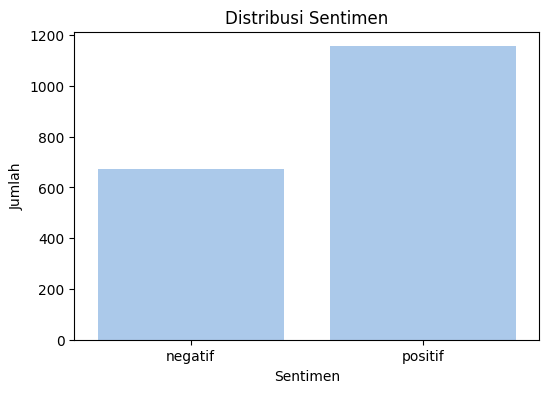

In [22]:
sns.set_palette('pastel')
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [23]:
# memisahkan data positif dan negatif
data_negatif = df[df['sentiment'] == 'negatif']
data_positif = df[df['sentiment'] == 'positif']

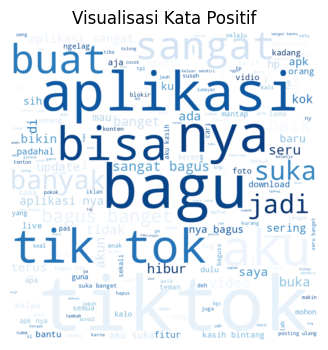

In [24]:
# Hapus nilai NaN terlebih dahulu
data_positif = data_positif.dropna(subset=['content'])

# Konversi kolom 'content' menjadi string
data_positif['content'] = data_positif['content'].astype(str)

# Gabungkan semua kata dalam kolom 'content'
all_text_s1 = ' '.join(word for word in data_positif['content'])

# Buat word cloud
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)

# Visualisasikan word cloud
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualisasi Kata Positif')
plt.margins(x=0, y=0)
plt.show()

<ipython-input-25-5cbf7e88979a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_negatif['content'] = data_negatif['content'].astype(str).dropna()


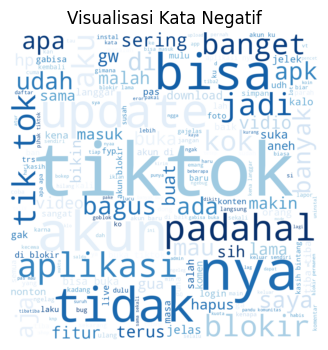

In [25]:
# Pastikan kolom 'content' berisi string dan hapus nilai NaN
data_negatif['content'] = data_negatif['content'].astype(str).dropna()

# Gabungkan semua kata dalam kolom 'content'
all_text_s1 = ' '.join(word for word in data_negatif['content'])

# Buat word cloud
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)

# Visualisasikan word cloud
plt.figure(figsize=(6,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Visualisasi Kata Negatif')
plt.margins(x=0, y=0)
plt.show()


#Splitting Data

In [26]:
x = df.content
y = df.sentiment

In [27]:
from sklearn.model_selection import train_test_split

# Pastikan ada tanda koma antara x_test dan y_train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#Training Data

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

cvec = CountVectorizer()
tvec = TfidfVectorizer()
hvec = HashingVectorizer()

In [29]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf1 = SVC(kernel='linear')
clf2 = MultinomialNB()
clf3 = RandomForestClassifier()

In [30]:
from sklearn.pipeline import Pipeline

model1 = Pipeline([('vectorizer', tvec), ('classifier', clf1)])
model2 = Pipeline([('vectorizer', tvec), ('classifier', clf2)])
model3 = Pipeline([('vectorizer', tvec), ('classifier', clf3)])

In [42]:
# Menghapus baris yang mengandung nilai NaN dalam x_train dan y_train
x_train = x_train.dropna()
y_train = y_train[x_train.index]

# Menghapus baris yang mengandung nilai NaN dalam x_test dan y_test (jika diperlukan)
x_test = x_test.dropna()
y_test = y_test[x_test.index]

# Memastikan tipe data string
x_train = x_train.astype(str)
x_test = x_test.astype(str)

# Panjang data train dan data test
train_length = len(x_train)
test_length = len(x_test)

print(f"Panjang data train: {train_length}")
print(f"Panjang data test: {test_length}")

# Melatih model dengan data bersih
model1.fit(x_train, y_train)


Panjang data train: 1464
Panjang data test: 366


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [41]:
# Inisialisasi vectorizer dan model
tvec = TfidfVectorizer()
clf1 = MultinomialNB()

# Membuat pipeline
model1 = Pipeline([('vectorizer', tvec), ('classifier', clf1)])

# Melatih model
model1.fit(x_train, y_train)

# Membuat prediksi
hasil1 = model1.predict(x_test)

# Membuat classification report
matrix = classification_report(y_test, hasil1)
print('Classification report: \n', matrix)

Classification report: 
               precision    recall  f1-score   support

     negatif       0.69      0.39      0.50       134
     positif       0.72      0.90      0.80       232

    accuracy                           0.71       366
   macro avg       0.71      0.64      0.65       366
weighted avg       0.71      0.71      0.69       366



In [34]:
# Inisialisasi vectorizer dan model
tvec = TfidfVectorizer()
clf2 = MultinomialNB()

# Membuat pipeline
model2 = Pipeline([('vectorizer', tvec), ('classifier', clf2)])

# Melatih model
model2.fit(x_train, y_train)

# Membuat prediksi
hasil2 = model2.predict(x_test)

# Membuat classification report
matrix = classification_report(y_test, hasil2)
print('Classification report: \n', matrix)

Classification report: 
               precision    recall  f1-score   support

     negatif       0.69      0.39      0.50       134
     positif       0.72      0.90      0.80       232

    accuracy                           0.71       366
   macro avg       0.71      0.64      0.65       366
weighted avg       0.71      0.71      0.69       366



In [36]:
# Inisialisasi vectorizer dan model
tvec = TfidfVectorizer()
clf2 = MultinomialNB()

# Membuat pipeline
model3 = Pipeline([('vectorizer', tvec), ('classifier', clf3)])

# Melatih model
model3.fit(x_train, y_train)

# Membuat prediksi
hasil3 = model3.predict(x_test)

# Membuat classification report
matrix = classification_report(y_test, hasil3)
print('Classification report: \n', matrix)

Classification report: 
               precision    recall  f1-score   support

     negatif       0.61      0.44      0.51       134
     positif       0.72      0.84      0.77       232

    accuracy                           0.69       366
   macro avg       0.66      0.64      0.64       366
weighted avg       0.68      0.69      0.68       366



In [37]:
hasilSupportVectorMachine = accuracy_score(hasil1,y_test)
precition1 = precision_score(y_test, hasil1, average='weighted')
recall1 = recall_score(y_test, hasil1, average='weighted')
f1_1 = f1_score(y_test, hasil1, average='weighted')

hasilMultinomialNB = accuracy_score(hasil2,y_test)
precition2 = precision_score(y_test, hasil2, average='weighted')
recall2 = recall_score(y_test, hasil2, average='weighted')
f1_2 = f1_score(y_test, hasil2, average='weighted')

hasilRandomForestClassifier = accuracy_score(hasil3,y_test)
precition3 = precision_score(y_test, hasil3, average='weighted')
recall3 = recall_score(y_test, hasil3, average='weighted')
f1_3 = f1_score(y_test, hasil3, average='weighted')

In [38]:
model = {'Model' : ['Support Vector Machine',
                    'Multinomial Naive bayes',
                    'Random Forest Classifier',
                    ],
         'AccuracyScore': [hasilSupportVectorMachine, hasilMultinomialNB, hasilRandomForestClassifier],
         'Precision': [precition1, precition2, precition3],
         'Recall': [recall1, recall2, recall3],
         'F1-Score': [f1_1, f1_2, f1_3]
         }
model_df = pd.DataFrame(model)
model_df

,Model,AccuracyScore,Precision,Recall,F1-Score
0,Support Vector Machine,0.754098,0.751449,0.754098,0.752399
1,Multinomial Naive bayes,0.713115,0.709104,0.713115,0.688803
2,Random Forest Classifier,0.691257,0.679839,0.691257,0.677931
